In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import openslide
import pyvips
from tqdm import tqdm
import json
import cv2

In [3]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [26]:
username = 'marzahl'
password = '****'
wsi_paths = "../Slides"
host =  "https://exact.cs.fau.de/"
result_folder = "DensityResults"

image_set_ids = [251]

screened = [
    '10052_19 humane BAL Berliner Blau-001.svs',
    '10080_19 humane BAL Berliner Blau-001.svs',
    '10120_19 humane BAL Berliner Blau.svs',
    '10227_19 humane BAL Berliner Blau.svs',
    '10672_19 humane BAL Berliner Blau.svs',
    '10672_19 humane BAL Turnbull Blau.svs',
    '10835_19 humane BAL Berliner Blau.svs',
    '10835_19 humane BAL Turnbull Blau.svs',
    '11323_19 humane BAL Berliner Blau.svs',
    '11480_19 humane BAL Berliner Blau.svs',
    '2707_20 TB BAL Human neu.svs',
    '2702_20 BB Human BAL-001.svs'
]

In [27]:
configuration = Configuration()
configuration.username = username
configuration.password = password
configuration.host =  host

In [28]:
client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)

images = {}
annotation_types = {}

In [29]:
total_annotations = {}
for image_set in image_set_ids:
    total_annotations[image_set] = []
    for image in images_api.list_images(pagination=False, image_set=image_set).results:
        if image.name in screened:
            images[image.name] = image
    for product in [3]:
        for anno_type in annotation_types_api.list_annotation_types(product=product).results:
            annotation_types[anno_type.id] = anno_type

In [30]:
list(images.keys())

['2702_20 BB Human BAL-001.svs',
 '2707_20 TB BAL Human neu.svs',
 '10052_19 humane BAL Berliner Blau-001.svs',
 '10080_19 humane BAL Berliner Blau-001.svs',
 '10120_19 humane BAL Berliner Blau.svs',
 '10227_19 humane BAL Berliner Blau.svs',
 '10672_19 humane BAL Berliner Blau.svs',
 '10672_19 humane BAL Turnbull Blau.svs',
 '10835_19 humane BAL Berliner Blau.svs',
 '10835_19 humane BAL Turnbull Blau.svs',
 '11323_19 humane BAL Berliner Blau.svs',
 '11480_19 humane BAL Berliner Blau.svs']

In [31]:
level = 0
down_factor = 1
files = {p.name:p for p in Path(wsi_paths).glob("**/*.svs")}


for image in tqdm(images.values()):
    
    result_folder = Path("../../DensityResults") / str(image.image_set)
    result_folder.mkdir(exist_ok=True, parents=True)

    density_dict = {}

    annos = annotations_api.list_annotations(image=image.id, pagination=False, deleted=False, fields="id,vector,unique_identifier,annotation_type,meta_data").results

    for anno in annos:

        if anno.meta_data is None:
            continue

        regression_value = anno.meta_data["Score"]
        
        if float(regression_value) < 0.5:
            anno.annotation_type = 6 #0
        elif float(regression_value) < 1.5:
            anno.annotation_type = 7 #1
        elif float(regression_value) < 2.5:
            anno.annotation_type = 8 #2
        elif float(regression_value) < 3.5:
            anno.annotation_type = 9 #3
        else:
            anno.annotation_type = 10 #4
        
        
        regression_value = int(min(4, max(0, float(regression_value))) * 100)       

        if regression_value not in density_dict:
            density_dict[regression_value] = []

        density_dict[regression_value].append(anno)

    max_patches_per_bin = max(len(values) for values in density_dict.values())
    patch_size = 60
    num_y_patches = 250

    x_total_size = patch_size * (400 + 1)
    y_total_size = patch_size * (num_y_patches + 1)

    big_image = np.zeros(shape=(y_total_size, x_total_size, 3), dtype=np.uint8)
    big_image += 255

    key = 0

    slide_path = files[image.name]
    slide = openslide.open_slide(str(slide_path))

    target_file = Path(image.filename.replace("svs", "tiff"))
    result_annotations = []

    for x in range(0, 400):
        if x in density_dict:
            annotations = density_dict[x]

            anno_counter = 0
            for anno in annotations:

                # if image hight is reached start with new column
                if anno_counter == num_y_patches:
                    anno_counter = 0
                    key += 1

                # if end of bin image increase big image size
                if key * patch_size >= x_total_size:
                    z = np.zeros((y_total_size, 1000, 3), dtype=np.uint8)
                    z += 255
                    big_image = np.concatenate((big_image, z), axis=1)

                    x_total_size += max(1000, w)
                

                x1, y1, w, h = anno.vector["x1"], anno.vector["y1"], anno.vector["x2"] - anno.vector["x1"], anno.vector["y2"] - anno.vector["y1"]  
                patch = np.array(slide.read_region(location=(int(x1 * down_factor), int(y1 * down_factor)),
                                                level=level, size=(w, h)))[:, :, :3]

                patch = cv2.resize(patch, (patch_size, patch_size))

                min_x = (key * patch_size)
                min_y = y_total_size - (anno_counter * patch_size)

                max_x, max_y = min_x + patch_size, min_y - patch_size
                big_image[max_y:min_y, min_x:max_x] = patch   

                box_dict = json.dumps({"x1": min_x + 5, "y1": max_y + 5, "x2": max_x - 5, "y2": min_y - 5})

                label = annotation_types[anno.annotation_type].name
                uuid = anno.unique_identifier
                row = "{0}|{1}|{2}||{3}".format(str(target_file), label, box_dict, uuid) + "\n"
                result_annotations.append(row)

                anno_counter += 1

            key += 1


    height, width, bands = big_image.shape
    linear = big_image.reshape(width * height * bands)
    vi = pyvips.Image.new_from_memory(linear.data, width, height, bands, 'uchar')
    vi.tiffsave(str(result_folder / target_file), tile=True, compression='lzw', bigtiff=True, pyramid=True)

    total_annotations[image.image_set].extend(result_annotations)
    with open('{}/label.txt'.format(str(result_folder)), 'w') as f:
        f.writelines(total_annotations[image.image_set])
    
    
    with open('{}/{}_label.txt'.format(str(result_folder), str(target_file.stem)), 'w') as f:
        f.writelines(result_annotations)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [18:50<00:00, 94.18s/it]


In [17]:
slide = openslide.open_slide(str(result_folder / target_file))
slide

OpenSlide('..\\..\\DensityResults\\251\\11480_19 humane BAL Berliner Blau.tiff')

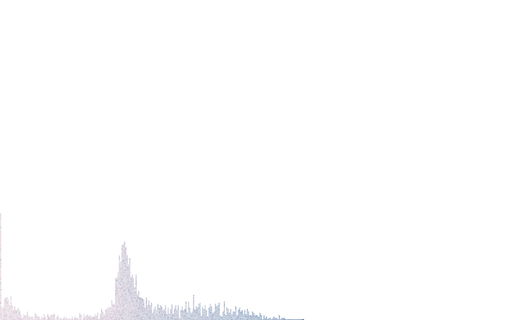

In [18]:
slide.get_thumbnail(size=(512,512))

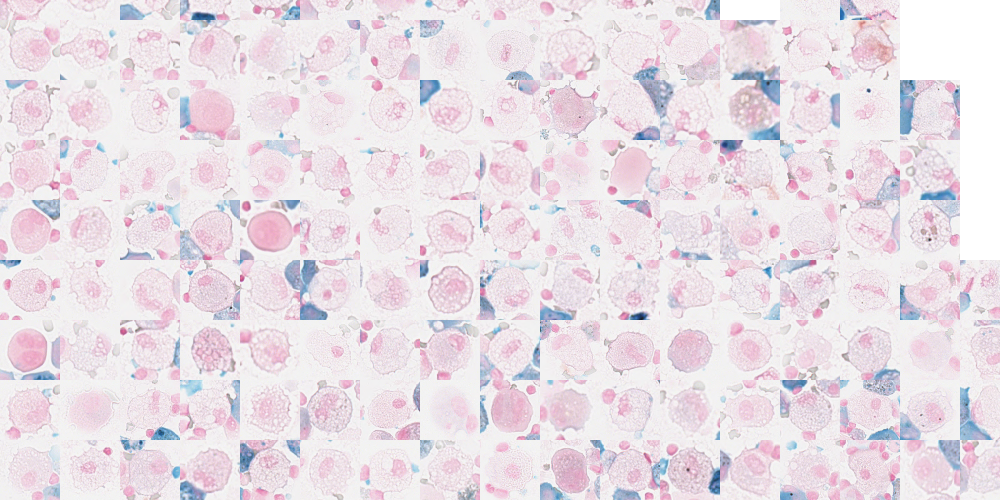

In [19]:
slide.read_region(location=(0, y_total_size-500), level=0, size=(1000,500))